<a href="https://colab.research.google.com/github/sheikanees/sunspots/blob/master/Predicting_number_of_Sunspots_present_on_surface_of_the_Sun_using_Conv1D_and_LSTM_layers_(time_series_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting number of Sunspots present on surface of the Sun using Conv1D and LSTM layers (time-series data)**

Sunspots, a temporary phenomena, are found on the Sun's surface and indicates intense magnetic activity. Most solar flares and coronal mass ejections occur around sunspot groupings. Individual sunspots or groups of sunspots may last anywhere from a few days to a few months, but eventually decay. Sunspots expand and contract as they move across the surface of the Sun, with diameters ranging from 16 km to 160,000 km.

The amount of magnetic flux that rises up to the Sun's surface varies with time in a cycle called the solar cycle. This cycle lasts 11 years on average. Since sunspots are directly related to magnetic activity, the sunspot cycle lasts 11 years too.

Data since the year 1749 to July 2018 of monthly mean total number of sunspots can be found in this link and is used in this study to form a model that can predict sunspot activity for the upcoming years.
https://www.kaggle.com/robervalt/sunspots/

Author: Sheik Mohamed Anees S/O S A F

In [1]:
!pip install tensorflow==2.0.0b1

**Importing the necessary libraries**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

**Loading the sunspot data**

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-10-26 17:44:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c0f::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-10-26 17:44:36 (99.3 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
#Function for plotting the sunspot data:
def plot_series(time, series):
    plt.plot(time, series)
    plt.xlabel("Time (no. of months)", color = 'r')
    plt.ylabel("Monthly Mean Total Sunspot Number", color = 'r')
    plt.grid(True)
    plt.tick_params(axis='x', colors='red')
    plt.tick_params(axis='y', colors='red')

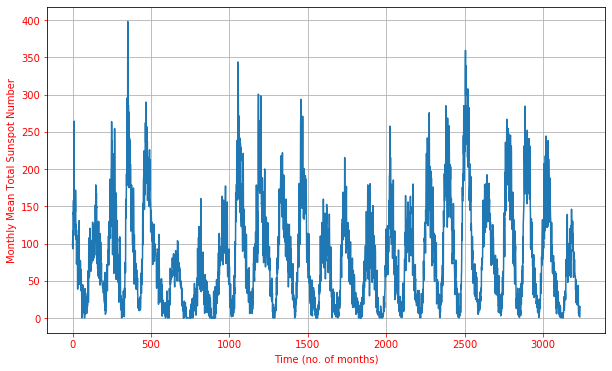

In [5]:
#Reading in the data
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

There is 3235 number of data points in the dataset representing 3235 months of data since the year 1749.

Science tells us that Sunspot data is a periodic series with a period of 11/22 years.  As we can see from the graph above, 11 years is 132 months and hence for every 500 months, we see roughly 4-5 cycles. 

**Function for preparing the training data to be fed into the machine learning model**

In [0]:
#Converting the dataset into a windowed dataset.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

window_size denotes the period that will be fed into the model per training example e.g 30 day window.  Typically, for periodic data, unless the period for each cycle is very long, the window_size will be the length of cycle.  batch_size refers to how many training examples per batch.  Shuffle buffer is the number of training examples that are shuffled (like batch size)

1) The tf.expand_dims line expands the dimension by 1 because later on for RNN layers such as LSTM layers etc, it requires a 3 dimensional input (batch_size, window_size, no. of variables) and no. of variables depends on whether its a univariate or multivariate system.

2) The ds.window line performs the windowing of the dataset.  For example for a series of [0,1,2,3,4,5,6,7,8,9], the ds.window with a window size of 5 and a shift of 1 forms [0,1,2,3,4], [1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7], [4,5,6,7,8] and [5,6,7,8,9] and drop remainder=True ensures that no series with less than 5 values forms e.g. [6,7,8,9].

3) the ds.shuffle line performs shuffling by shuffle_buffer size(like batches) instead of the entire training size because that is potentially computationaly expensive

4) the ds.map function seperates the final value in each training example so for example [0,1,2,3] -> [4], [1,2,3,4] -> [5]...

5) the return ds.batch function does the batching of the training examples to be fed into the machine learning model.
 



**Function for preparing the validation data for forecasting**

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

**Parameters for the model**

In [9]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(np.shape(x_train))

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


As mentioned earlier, there are 3235 datapoints and the datapoints are split such that the first 3000 are split as training data and the last 235 as validation data.

**Creating the model**

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
12/12 [==============================] - 9s 720ms/step - loss: 70.6471 - mae: 71.0255
Epoch 2/100
12/12 [==============================] - 6s 461ms/step - loss: 69.5055 - mae: 69.9089
Epoch 3/100
12/12 [==============================] - 6s 465ms/step - loss: 67.8075 - mae: 68.2222
Epoch 4/100
12/12 [==============================] - 6s 462ms/step - loss: 65.7075 - mae: 66.1338
Epoch 5/100
12/12 [==============================] - 6s 468ms/step - loss: 63.2065 - mae: 63.6457
Epoch 6/100
12/12 [==============================] - 6s 479ms/step - loss: 60.2447 - mae: 60.6979
Epoch 7/100
12/12 [==============================] - 6s 469ms/step - loss: 56.7976 - mae: 57.2642
Epoch 8/100
12/12 [==============================] - 6s 478ms/step - loss: 52.9596 - mae: 53.4366
Epoch 9/100
12/12 [==============================] - 6s 464ms/step - loss: 49.0408 - mae: 49.5211
Epoch 10/100
12/12 [====

The tf.keras.layers.Lambda layer ensures that the output of the layer which has a tanh activation by default (which is in the range of -1 to 1) matches the output range of the series (sunspot data) which is in the range of 1-400 and hence is scaled up by 400.  This step is very important.

The first run of a 100 epochs will help determine what is the optimum learning rate for this model.  This is achieved with the help of the learning rate schedular which increases the learning rate slightly for every epoch.

Mean Absolute Error was chosen as the metric.  Huber was chosen as the loss optimizer.

Text(0, 0.5, 'MAE')

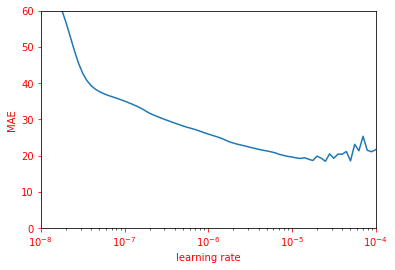

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.tick_params(axis='x', colors='red')
plt.tick_params(axis='y', colors='red')
plt.xlabel("learning rate", color = 'r')
plt.ylabel("MAE", color = 'r')

From the plot above, the learning rate decreased to 10^-5 before becoming unstable.  Hence, the optimum learning rate is 10^-5.

**Training the model**

In [14]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 262ms/step - loss: 38.8777 - mae: 39.6295
Epoch 2/500
30/30 [==============================] - 5s 172ms/step - loss: 23.3702 - mae: 23.8993
Epoch 3/500
30/30 [==============================] - 5s 171ms/step - loss: 21.7150 - mae: 22.1711
Epoch 4/500
30/30 [==============================] - 5s 177ms/step - loss: 20.8903 - mae: 21.3763
Epoch 5/500
30/30 [==============================] - 5s 170ms/step - loss: 19.3689 - mae: 19.8634
Epoch 6/500
30/30 [==============================] - 5s 168ms/step - loss: 19.1591 - mae: 19.6500
Epoch 7/500
30/30 [==============================] - 5s 167ms/step - loss: 19.1644 - mae: 19.6307
Epoch 8/500
30/30 [==============================] - 5s 170ms/step - loss: 19.0039 - mae: 19.5043
Epoch 9/500
30/30 [==============================] - 5s 174ms/step - loss: 18.6450 - mae: 19.1344
Epoch 10/500
30/30 [==============================] - 5s 170ms/step - loss: 18.5617 - mae: 19.0623
Epoch 11/500
30/30 

**Analyzing training and validation loss per epoch**

<Figure size 432x288 with 0 Axes>

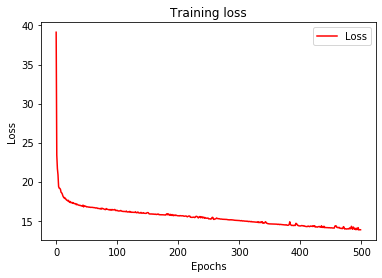

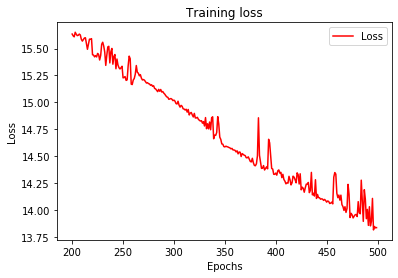

<Figure size 432x288 with 0 Axes>

In [15]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

# Plotting training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

# Plot zoomed in training and validation loss per epoch
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

**Forecasting & Checking Accuracy of Model**

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)  #using the function created earlier
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]  

the data is in a 3 dimensional format we want to only select after split time(minus the window size).

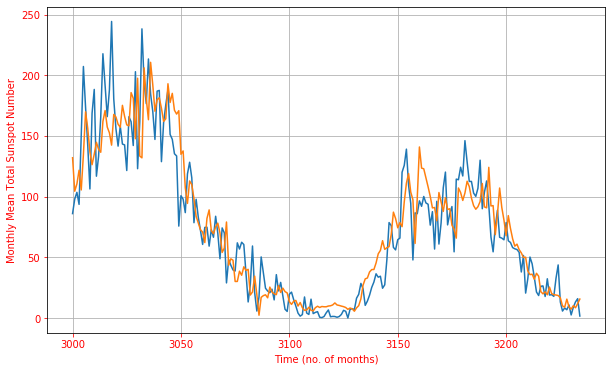

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.764301